#**X-Ray Production**

**Observations:**

This experiment was peformed at the Institute of Physics, University of São Paulo in 2022 and it is part of modern physics laboratory classes. It was used NaCl to diffract X-Ray. 

**Experiment main goals:**

1.   To determine the X-Ray emission spectra of Mo tube (Count vs Energy): characteristic radiation and bremsstrahlung radiation.
2.   To determine the Planck constant from the bremsstrahlung radiation.
3.   To evaluate the relation between θmin and acceleration potencial difference (or Emax) (V).

OBS.: the potential difference is sometimes refered as ddp in the code, which comes from 'diferença de potencial' in portuguese

**Datasets observations:**



*   The first dataset consists of 3 subsets at the angle range from θmin = 2.5̊  and θmax = 30̊ , Δt = 1s, Δθ = 0.1̊ , I = 1 mA and U = 35 kV.
*   The second dataset consists of 10 subsets with 5 different tension values, and for each tension value there is 2 values of Δt: 1s and 5s. All subsets were measured at the angle range from θmin = 2.5̊  and θmax = 12̊, I = 1 mA, and Δθ = 0.1̊. The tension values are: 18 kV, 25 kV, 28 kV, 30 kV and 35 kV.


**Experiment observations:**



*   The uncertainty in maximum energy (θmin) is 1%.
*   The equipament uncertainty in θ is 0.05̊.
*   The equipment software delivers the count  column divided by Δt, so in the case of sets where Δt = 5s we have to multiply the count column by 5 and then add the influence of time in the uncertainty calculation: σ(N) = $\sqrt{N}$/Δt.




**Importing libraries:**

In [102]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import linregress as lr
from scipy import odr
import math

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Dataset 1:**

*   Comment qualitatively the observed spectra (continuous spectra and characteristic lines).
*   How to evaluate the experimental uncertainties?
*   Does the characteristic energies match to the expected ones?
*   Does the angles to n=2 and n=3 match to the expected ones?

**Analysis infos:**

*   The X-Ray detection obbey the Poisson distribution function. That is why the uncertanty is given by σ(N) = $\sqrt{N}$/Δt (N is the sum of the photons in time interval Δt).
*   To calculate characteristic peaks (kα and kβ) energies, first we obtain λ from θ values applied in Bragg equation **nλ = 2dsin(θ)**, where d = 0.282 nm (d value for NaCl), n=1. To calculate energy we calculate **E = hc/λ**.
   * **h = $4.14×10^{−15}$  eV s**
   * **c =  $3×10^8$  m/s**
*   To verify the angles for n = 2 and n = 3 we apply the λ found for n = 1 and compare them with the values from the graph curves. 
*   The expected values for kα and kβ are:
    * **kα = 17.44 eV**
    * **kβ = 19.60 eV**





**Reading datasets:**

In [ ]:
def read_c1(num):
  num = str(num)
  d1 = np.loadtxt(f'/content/drive/MyDrive/Raio X/Raio X/Dados/c1-{num}.txt', skiprows=1, dtype=np.str)
  d2 = np.char.replace(d1, ',', '.').astype(np.float64)
  return pd.DataFrame(d2, columns=['\u03B8 (°)','Count'])

 

#Dataset 1:
c1_1 = read_c1(1)  #subset 1
c1_2 = read_c1(2)  #subset 2
c1_3 = read_c1(3)  #subset 3


**Checking datasets:**

In [ ]:
c1_1

**Merging the 3 subsets from dataset 1 to a dataset called c1:**

In [ ]:
merge1c1 = pd.merge(c1_1, c1_2, how='outer', on = '\u03B8 (°)')
c1 = pd.merge(merge1c1, c1_3, how='outer', on = '\u03B8 (°)')
c1.columns = ['\u03B8 (°)', 'Count 1', 'Count 2', 'Count 3']

#Add the extra column summing the column values up and the column with uncertainties:
c1['Count Total'] = c1['Count 1'] + c1['Count 2'] + c1['Count 3']
c1['σ'] = np.sqrt(c1['Count Total'])

**Plotting the 3 subsets together:**

In [ ]:
p1 = go.Scatter(x=c1['\u03B8 (°)'], y=c1['Count 1'], mode='lines', name='Count 1')
p2 = go.Scatter(x=c1['\u03B8 (°)'], y=c1['Count 2'], mode='lines', name='Count 2')
p3 = go.Scatter(x=c1['\u03B8 (°)'], y=c1['Count 3'], mode='lines', name='Count 3')

plots1 = [p1,p2,p3]
layout1 = go.Layout(title='X-Ray detection - Dataset 1')
figure1 = go.Figure(data=plots1, layout=layout1)
figure1

**Plotting the total count:**

This is done to improve statistics.

In [ ]:
figure2 = px.line(c1, x='\u03B8 (°)', y='Count Total', title = 'X-Ray Detection - Total Count', error_y=c1['σ'])
figure2

**Selecting peaks to fit gaussian for n=1:**



In [ ]:
c1x = c1['θ (°)']
c1y = c1['Count Total']
c1_s = c1['σ']

#kβ:
c1x_b = c1x[(c1x >= 6.1) & (c1x <= 6.6)] # x values for kβ peak
c1y_b = c1y[(c1x >= 6.1) & (c1x <= 6.6)] # y values for kβ peak
c1_s_b = c1_s[(c1x >= 6.1) & (c1x <= 6.6)] # sigma count values for kβ peak
c1_b = pd.DataFrame({'x': c1x_b,'y': c1y_b, 'sy':c1_s_b})

#kα:
c1x_a = c1x[(c1x >= 6.9) & (c1x <= 7.6)] # x values for kα peak
c1y_a = c1y[(c1x >= 6.9) & (c1x <= 7.6)] # y values for kα peak
c1_s_a = c1_s[(c1x >= 6.9) & (c1x <= 7.6)] # sigma count values for kα peak 
c1_a = pd.DataFrame({'x': c1x_a,'y': c1y_a, 'sy':c1_s_a})

#Checking the .describe() function:

c1x_a.describe()

**The fitting was performed in two different ways: lmfit and scipy curve_fit**

#**Fitting with lmfit**

*  It is not included here the count uncertainties.

In [ ]:
!pip install lmfit

In [ ]:
from lmfit import Model

def gaussian(x, amp, cen, wid):
    return amp*np.exp(-(x-cen)**2/(2*wid**2))

#Fitting kβ:
b_gmodel = Model(gaussian)
b_result = b_gmodel.fit(c1_b['y'], x=c1x_b, amp=2700, cen=6.3, wid=0.2)
print(b_result.fit_report())


plt.plot(c1x_b, c1y_b, 'o')
plt.plot(c1x_b, b_result.init_fit, '--', label='Initial fit')
plt.plot(c1x_b, b_result.best_fit, '-', label='Best fit')
plt.title('Fitting kβ')
plt.legend()
plt.show()

In [ ]:
#Fitting kα:
a_gmodel = Model(gaussian)
a_result = a_gmodel.fit(c1y_a, x=c1x_a, amp=5700, cen=7.2, wid=0.1)

print(a_result.fit_report())

plt.plot(c1x_a, c1y_a, 'o')
plt.plot(c1x_a, a_result.init_fit, '--', label='initial fit')
plt.plot(c1x_a, a_result.best_fit, '-', label='best fit')
plt.title('Fitting kα')
plt.legend()
plt.show()

**Residuals:**

In [ ]:
# Residuals for kβ:
residuals_b1 = c1y_b - b_result.best_fit
plt.scatter(c1y_b, residuals_b1)
plt.axhline(y=0, c='red', ls='--')
plt.title('Residuals kβ, n=1')

In [ ]:
# Residuals for kα:
residuals_a1 = c1y_a - a_result.best_fit
plt.scatter(c1y_a, residuals_a1)
plt.axhline(y=0, c='red', ls='--')
plt.title('Residuals kα, n=1')

#**Fitting with curve_fit:**


*   It was included the count uncertainties.



In [ ]:
def gauss (x, amp, cen, wid):  #amp=ymax, cen=center of the curve, wid=width of the curve
    return amp*np.exp(-(x-cen)**2/(2*wid**2))

#Fitting kβ:
popt_b, pcov_b = curve_fit(gauss, c1_b['x'], c1_b['y'], sigma=c1_b['sy'], p0=[2000,6.3,0.2])
a = popt_b[0]
x0 = popt_b[1]
sigma = popt_b[2]
plt.plot(c1_b['x'],c1_b['y'], 'bo', label='Data')
plt.errorbar(c1_b['x'],c1_b['y'],yerr=c1_b['sy'], color='b')
plt.plot(c1_b['x'], gauss(c1_b['x'],*popt_b), color='r', label='Fit:' + '$\mathcal{N}$' + f'$(\mu \\approx {round(x0, 1)}, \sigma \\approx {round(sigma,2)})$')
plt.legend()
print('Params:','\n',popt_b, '\n','\n','Cov matrix:','\n', pcov_b)

In [ ]:
#Fitting kα:
popt_a, pcov_a = curve_fit(gauss, c1_a['x'], c1_a['y'], sigma=c1_a['sy'], p0=[5000,7.2,0.1])
a = popt_a[0]
x0 = popt_a[1]
sigma = popt_a[2]
plt.plot(c1_a['x'],c1_a['y'], 'go', label='Data')
plt.errorbar(c1_a['x'],c1_a['y'],yerr=c1_a['sy'], color='g')
plt.plot(c1_a['x'], gauss(c1_a['x'],*popt_a), color='purple', label='Fit:' + '$\mathcal{N}$' + f'$(\mu \\approx {round(x0, 1)}, \sigma \\approx {round(sigma,2)})$')
plt.legend()
print('Params:','\n',popt_a, '\n','\n','Cov matrix:','\n', pcov_a)

#**Comparing fits:**

In [ ]:
print('Result for kβ usando lmfit:','\n')
display(b_result)
print('\n')

print('Result for kα usando lmfit:','\n')
display(a_result)
print('\n')

print('Result for kβ usando curve_fit:','\n')
print('amp:',popt_b[0],'|','inc:', np.sqrt(pcov_b[0][0]),'|','relative error:',(np.sqrt(pcov_b[0][0])/popt_b[0])*100,'%','\n',
      'cen:',popt_b[1],'|','inc:', np.sqrt(pcov_b[1][1]),'|','relative error:',(np.sqrt(pcov_b[1][1])/popt_b[1])*100,'%','\n',
      'wid:',popt_b[2],'|','inc:', np.sqrt(pcov_b[2][2]),'|','relative error:',(np.sqrt(pcov_b[2][2])/popt_b[2])*100,'%')
print('\n')

print('Result for kα usando curve_fit:','\n')
print('amp:',popt_a[0],"|",'inc:', np.sqrt(pcov_a[0][0]),'|','relative error:',(np.sqrt(pcov_a[0][0])/popt_a[0])*100,'%','\n',
      'cen:',popt_a[1],'|','inc:', np.sqrt(pcov_a[1][1]),'|','relative error:',(np.sqrt(pcov_a[1][1])/popt_a[1])*100,'%','\n',
      'wid:',popt_a[2],'|','inc:', np.sqrt(pcov_a[2][2]),'|','relative error:',(np.sqrt(pcov_a[2][2])/popt_a[2])*100,'%')
print('\n')


**$R^2$:**

In [ ]:
def rsquared(y, yfit):
    slope, intercept, r_value, p_value, std_err = lr(y, yfit)
    return r_value**2

# R2 values for lmfit:
b_r2_lm = rsquared(c1_b['y'], b_result.best_fit)
a_r2_lm = rsquared(c1_a['y'], a_result.best_fit)

# R2 values for curve_fit():
b_r2_cf = rsquared(c1_b['y'], gauss(c1_b['x'],*popt_b))
a_r2_cf = rsquared(c1_a['y'], gauss(c1_a['x'],*popt_a))

print(a_r2_cf, a_r2_lm, b_r2_cf,b_r2_lm)

#**Applying the parameters fitted with lmft to calculate λ:**


*   OBS.: Comparing the fitting methods it is possible to conclude there is no big difference between parameters and its uncertainties values looking to relative errors and $R^2$.



In [ ]:
#Calculating λ from fitted θ values. These values are the 'cen' parameter,
#which is the mean of gaussian curve fitted. Let's apply Bragg equation: nλ=2dsen(θ) => λ = 2dsen(θ)

d = 0.282*10**(-9) #meters
#kβ:
lambda_b = 2*d*np.sin(6.3511*(np.pi/180))

#Para kα:
lambda_a = 2*d*np.sin(7.18760*(np.pi/180))

**Calculating energy from λ and comparing them to the expected values:**

Energy equation: E = hc/λ

In [ ]:
h = 4.14*10**(-15) #eV s
c = 3*10**8 #m/s

#Expected values:
E_ka_t = 17440 #eV  
E_kb_t = 19600 #eV

#kβ:
E_b = (h*c)/lambda_b
desvio_a = (abs(E_b - E_kb_t)/E_kb_t)*100 #desvio percentual de 0.92%

#kα:
E_a = (h*c)/lambda_a
desvio_b = (abs(E_a - E_ka_t)/E_ka_t)*100 #desvio percentual de 1.57%

**Verifying the angles for n = 2 and n = 3:**

n = 2:

In [ ]:
#kα:
theta_a_n2 = np.arcsin(lambda_a/d)*(180/np.pi) #degrees

#kβ:
theta_b_n2 = np.arcsin(lambda_b/d)*(180/np.pi) #degrees

#I did quick check using the plotted figure.

n = 3:

In [ ]:
#kα:
theta_a_n3 = np.arcsin((3*lambda_a)/(2*d))*(180/np.pi) #degrees

#kβ:
theta_b_n3 = np.arcsin((3*lambda_b)/(2*d))*(180/np.pi) #degrees

#I did quick check using the plotted figure.

#**Dataset 2:**

*   Plot number of photons/second X Energy (keV).
*   Plot uncertainties.
*   Does the characteristic energies match to the expected ones? What are the percentage deviation? 
*   For each spectra (acceleration tension range from 18 kV to 35 kV) calculate the λmin value (through experimental values θmin or Emax).
*   Calculate Planck constant **h** from a acceleration tension X λmin plot.

**Analysis infos:**

*   The data aquisition software returns photons (counts)/second. To plot count/s X Energy, first calculate λ from θ values applying Bragg equation nλ = 2dsin(θ) and considering n=1. From these λ values it is possible to calculate energy and do the plots. To calculate the count uncertainties consider the calculation explained before: multiply count values from table by Δt then apply $\sqrt{N}$/Δt for each count data. The plot count/s X Energy must be done with the orginal values given by the software, so after calculate uncertainties divide the count values by Δt.
*   To calculate the characteristic energy let's fit gaussian function, the same way it was done for dataset 1.
*   The items above are going to be applied for all the 10 subsets and for each subset we obtain one λmin (which is the same for Δt = 1 s and Δt = 5 s for the same tension value). Then we plot Emax X λmin.
*   To calculate **h** we fit the Emax X λmin plot.


**Reading datasets:**

In [ ]:
def read_c2(tension, time):
  tensao = str(tension)
  tempo = str(time)
  #Constant values:
  h = 4.14*10**(-15) #eV s
  c = 3*10**8 #m/s
  d = 0.282*10**(-9) #meters

  d1 = np.loadtxt(f'/content/drive/MyDrive/Raio X/Raio X/Dados/c2-{tension}-{time}.txt', skiprows=1, dtype=np.str)
  d2 = np.char.replace(d1, ',', '.').astype(np.float64)
  d3 = pd.DataFrame(d2, columns=['\u03B8 (°)','Count'])
  lambdaa = 2*d*np.sin(d3['\u03B8 (°)']*np.pi/180)
  d3['Energy (keV)'] = ((h*c)/lambdaa)/1000
  d3['σx (°)'] = 0.05
  if tempo == '5':
    d3['Count'] = d3['Count']*5
    d3['σy'] = np.sqrt(d3['Count'])/5
    d3['Count'] = d3['Count']/5
  else:
    d3['σy'] = np.sqrt(d3['Count'])
  return d3

#Dataset 2: defining variables for quick check

c2_18_1 = read_c2(18,1) #U = 18 kV and Δt = 1s
c2_18_5 = read_c2(18,5) #U = 18 kV and Δt = 5s

c2_25_1 = read_c2(25,1) #U = 25 kV and Δt = 1s
c2_25_5 = read_c2(25,5) #U = 25 kV and Δt = 5s

c2_28_1 = read_c2(28,1) #U = 28 kV and Δt = 1s
c2_28_5 = read_c2(28,5) #U = 28 kV and Δt = 5s

c2_30_1 = read_c2(30,1) #U = 30 kV and Δt = 1s
c2_30_5 = read_c2(30,5) #U = 30 kV and Δt = 5s

c2_35_1 = read_c2(35,1) #U = 35 kV and Δt = 1s
c2_35_5 = read_c2(35,5) #U = 35 kV and Δt = 5s

**Plotting graphs:**

In [ ]:
def plot_energy():
  '''This function plots the energy data'''
  p = []
  delta = str(input('Delta time: '))
  while len(p) <= 4:
    ddp = str(input('Type ddp: '))
    time = str(input('Type time: '))
    data = read_c2(ddp,time)
    g = go.Scatter(x=data['Energy (keV)'], y=data['Count'], mode='lines+markers', name=f'{ddp} kV')
    p.append(g)
  layout = go.Layout(title=f'Count/s X Energy - Δt = {delta}s')
  figure = go.Figure(data=p, layout=layout)
  figure.update_xaxes(title_text='Energy (keV)')
  figure.update_yaxes(title_text='Count')
  return figure


def plot_theta():
  '''This function plots the theta data'''
  p = []
  delta = str(input('Delta time: '))
  while len(p) <= 4:
    ddp = str(input('Type ddp: '))
    time = str(input('Type time: '))
    data = read_c2(ddp,time)
    g = go.Scatter(x=data['\u03B8 (°)'], y=data['Count'], mode = 'lines+markers', name=f'{ddp} kV')
    p.append(g)
  layout = go.Layout(title=f'Count/s X Energy - Δt = {delta}s')
  figure = go.Figure(data=p, layout=layout)
  figure.update_xaxes(title_text='\u03B8 (°)')
  figure.update_yaxes(title_text='Count')
  return figure

def plot_one_energy():
  '''This function plots one curve, count X energy'''
  delta = str(input('Delta time: '))
  ddp = str(input('Type ddp: '))
  time = str(input('Type time: '))
  data = read_c2(ddp,time)
  figure = px.line(data, x='Energy (keV)', y='Count', title = f'Count/s vs Energy - Δt = {delta}s - U = {ddp} V', error_y=data['σy'])
  return figure

def plot_one_theta():
  '''This function plots one curve, count X theta'''
  delta = str(input('Delta time: '))
  ddp = str(input('Type ddp: '))
  time = str(input('Type time: '))
  data = read_c2(ddp,time)
  figure = px.line(data, x='\u03B8 (°)', y='Count', title = f'Count/s vs Angle - Δt = {delta}s - U = {ddp} V', error_y=data['σy'], error_x=data['σx (°)'])
  return figure

**Selecting the x axis range to fit the curves:**

*   Plot the 5 lines.
*   Define the range for kα and kβ peaks zooming the curves.
*   The range is going to be the same since the Δt doesn't change the energy of the peaks. 

In [ ]:
# Test cell
plot_energy()

In [ ]:
# Test cell
plot_one_energy()

**Δt = 5 s and Δt = 1 s:**

**kα:** 16.4 to 18.6

**kβ:** 18.9 to 20.7



##**Fitting the curves:**


**The function fitted is going to be the gaussian function.**

**First I will define a fucntion for each peak (kα and kβ) to estimate the initial parameters.**

**Then, I will define a function to fit both kα and kβ.**

In [ ]:
def estimate_param_ka(delta, ddp, time):
  '''This function allows to estimate parameters for kα curve to fit it and select the x axis to fit.'''
  delta = str(delta)
  ddp = str(ddp)
  time = str(time)
  data = read_c2(ddp,time)

  #x axis range selecting for kα: x, y, σy and σx
  xa = data['Energy (keV)'][(data['Energy (keV)'] >= 16.8) & (data['Energy (keV)'] <= 18.1)]
  ya = data['Count'][(data['Energy (keV)'] >= 16.8) & (data['Energy (keV)'] <= 18.1)]
  sya = data['σy'][(data['Energy (keV)'] >= 16.8) & (data['Energy (keV)'] <= 18.1)]
  sxa = data['σx (°)'][(data['Energy (keV)'] >= 16.8) & (data['Energy (keV)'] <= 18.1)]

  amp = np.max(ya)
  cen = np.median(xa)
  sigma = np.max(xa)-np.min(xa)

  return  [[amp, cen, sigma],[xa,ya,sya,sxa]]

  
def estimate_param_kb(delta, ddp, time):
  '''This function allows to estimate parameters for kβ curve to fit it, and select x axis to fit.'''
  delta = str(delta)
  ddp = str(ddp)
  time = str(time)
  data = read_c2(ddp,time)

  #x axis range selecting for kβ: x, y, σy and σx
  xb = data['Energy (keV)'][(data['Energy (keV)'] >= 18.9) & (data['Energy (keV)'] <= 20.7)]
  yb = data['Count'][(data['Energy (keV)'] >= 18.9) & (data['Energy (keV)'] <= 20.7)]
  syb = data['σy'][(data['Energy (keV)'] >= 18.9) & (data['Energy (keV)'] <= 20.7)]
  sxb = data['σx (°)'][(data['Energy (keV)'] >= 18.9) & (data['Energy (keV)'] <= 20.7)]

  amp = np.max(yb)
  cen = np.median(xb)
  sigma = np.max(xb)-np.min(xb)

  return [[amp, cen, sigma],[xb,yb,syb,sxb]]


**The curves are going to be fitted with ODR (Orthogonal Distance Regression) scipy algorithm due to errors in both x and y axes.**

In [32]:
def gauss (p,x):  #amp=ymax, cen=center of the curve, wid=width of the curve
    amp, cen, wid = p
    return amp*np.exp(-(x-cen)**2/(2*wid**2))

def fit_odr():
  delta = str(input('Delta time: '))
  ddp = str(input('Type ddp: '))
  time = str(input('Type time: '))
  data = read_c2(ddp,time)

  #kα curve:
  param_a = estimate_param_ka(delta, ddp, time)[0]
  feature_a = estimate_param_ka(delta, ddp, time)[1][0]
  target_a = estimate_param_ka(delta,ddp,time)[1][1]
  model_a = odr.Model(gauss)
  data_a = odr.RealData(feature_a, target_a, sx = estimate_param_ka(delta,ddp,time)[1][3], sy = estimate_param_ka(delta,ddp,time)[1][2])
  ordinal_distance_reg_a = odr.ODR(data_a, model_a, beta0=param_a)
  result_outputs_a = ordinal_distance_reg_a.run()

  #kβ curve:
  param_b = estimate_param_kb(delta, ddp, time)[0]
  feature_b = estimate_param_kb(delta, ddp, time)[1][0]
  target_b = estimate_param_kb(delta,ddp,time)[1][1]
  model_b = odr.Model(gauss)
  data_b = odr.RealData(feature_b, target_b, sx = estimate_param_kb(delta,ddp,time)[1][3], sy = estimate_param_kb(delta,ddp,time)[1][2])
  ordinal_distance_reg_b = odr.ODR(data_b, model_b, beta0=param_b)
  result_outputs_b = ordinal_distance_reg_b.run()

  popt_a = result_outputs_a.beta
  perr_a = np.sqrt(np.diag(result_outputs_a.cov_beta))

  popt_b = result_outputs_b.beta
  perr_b = np.sqrt(np.diag(result_outputs_b.cov_beta))


  fig, (ax1,ax2) = plt.subplots(2)
  ax1.plot(feature_a, target_a, 'bo', label='Data - kα')
  ax1.errorbar(feature_a,target_a,yerr=estimate_param_ka(delta, ddp, time)[1][2],xerr=estimate_param_ka(delta, ddp, time)[1][3], color='b')
  ax1.plot(feature_a, gauss(popt_a, feature_a), color='r', label= 'Fit - kα')
  ax1.set_title(f'Fit kα - U = {ddp} V - Δt = {delta}s')
  ax1.set_xlabel('E (keV)')
  ax1.set_ylabel('Count')
  ax1.legend()

  
  ax2.plot(feature_b, target_b, 'bo', label='Data - kβ')
  ax2.errorbar(feature_b,target_b,yerr=estimate_param_kb(delta, ddp, time)[1][2],xerr=estimate_param_kb(delta, ddp, time)[1][3], color='b')
  ax2.plot(feature_b, gauss(popt_b, feature_b), color='r', label= 'Fit - kβ')
  ax2.set_title(f'Fit kβ - U = {ddp} V - Δt = {delta}s')
  ax2.set_xlabel('E (keV)')
  ax2.set_ylabel('Count')
  ax2.legend()
  
  return ax1,result_outputs_a.pprint(), ax2, result_outputs_b.pprint()

In [ ]:
# Cell to fit curves:
fit_odr()

In [126]:
# Cell to save parameters:

**$R^2$:**

In [127]:
# Cell to calculate R^2:

#**Calculating h (Planck constant):**

**The next step is to plot Emax X λmin for each point to fit the curve and find h (Planck constant).**

**To do this, first we must find the λmin from the the count X θ plot. The λmin will be selected manually.**

**Plotting the graphs to estimate the λmin values:**

In [ ]:
plot_one_theta()

**Creating dataframe to keep the λ values:**

*  Store the θ values selected manually into a list.
*  Use the nλ = 2dsin(θ) to convert the θ values into λ values and propagate the uncertaities.
*  d = 0.282 nm, that is the same **d** applied before, the crystal parameter.
*  n = 1 
*  The values are the same for Δt = 1 s and Δt = 5 s.
*  The values Emax: 18 keV, 25 keV, 28 keV, 30 keV, 35 keV. The uncertainty is 1%.

In [34]:
# Crystal parameter d:
d = 0.282*(10**(-9)) #meters

thetas = [7, 5, 4.5, 4.1, 3.5] 
theta_sigma = 0.05

lambdas = []
lamda_sigma = []

for i in range (len(thetas)):
  lambdas.append(2*d*np.sin(thetas[i]*np.pi/180))
  convert = np.cos(thetas[i]*np.pi/180)
  sigma_lambda = 2*d*convert*theta_sigma
  lamda_sigma.append(sigma_lambda)


energy_lambda = pd.DataFrame({'λmin (m)': lambdas, 'σλ': lamda_sigma, 'Emax (keV)': [18, 25, 28, 30, 35], 'σE': [0.18, 0.25, 0.28, 0.30, 0.35]})
energy_lambda

,λmin (m),σλ,Emax (keV),σE
0,6.873431e-11,2.798980e-11,18,0.18
1,4.915584e-11,2.809269e-11,25,0.25
2,4.425093e-11,2.811307e-11,28,0.28
3,4.032456e-11,2.812783e-11,30,0.30
4,3.443138e-11,2.814740e-11,35,0.35


**Plotting the Emax X λmin graphs:**



In [ ]:
figure3 = px.line(energy_lambda, x='λmin (m)', y='Emax (keV)', title = 'Emax X λmin - Dataset 2', error_y=energy_lambda['σE'], error_x=energy_lambda['σλ'])
figure3

**Fitting with curve_fit:**

*   The energy was is multiplied by 1000 so the **h** value is given in eV.
*   The plot is λmin X Energy so I can use the λ uncertainties in curve_fit.

Params: 
 [4.09555628e-15] 
 
 Cov matrix: 
 [[4.26263502e-34]]


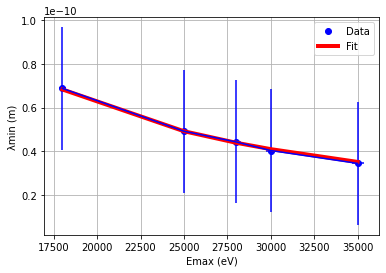

In [124]:
def fun (x, h): 
    c = 3*10**8 #m/s
    return (h*c)/x  #Here I am multiplying by 1 to symbolize the e (electron charge) value. 

popt_fun, pcov_fun = curve_fit(fun, energy_lambda['Emax (keV)']*1000, energy_lambda['λmin (m)'] , sigma=energy_lambda['σλ'])
a_fun = popt_fun[0]
plt.plot(energy_lambda['Emax (keV)']*1000, energy_lambda['λmin (m)'], 'bo', label='Data')
plt.errorbar(energy_lambda['Emax (keV)']*1000, energy_lambda['λmin (m)'], xerr=energy_lambda['σE']*1000, yerr=energy_lambda['σλ'], color='b')
plt.plot(energy_lambda['Emax (keV)']*1000, fun(energy_lambda['Emax (keV)']*1000, *popt_fun), color='r', label='Fit', lw=4)
plt.ylabel('λmin (m)')
plt.xlabel('Emax (eV)')
plt.grid()
plt.legend()
print('Params:','\n',popt_fun, '\n','\n','Cov matrix:','\n', pcov_fun)

**Checking the percentage deviation from theoritical value:**

*   Theoritical value: $4.13566743 × 10^{-15}$ eV . s

In [125]:
dev = (abs(4.09555628e-15 - 4.13566743e-15)/(4.13566743e-15))*100
print('The percentage deviation is:', dev)

The percentage deviation is: 0.9698833544746697
